In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

In [2]:
!pip install --upgrade statsmodels==0.13.2

<font face="Chalkboard" color="darkgreen" size=12>Multivariate Predictors, Models with Sparsity Patterns and Data Simulations</font>

In [3]:
# general imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import toeplitz
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

## Objective function for Square Root Lasso

$$\large \hat{\beta}_{SqrtLasso} =argmin_{\beta\in\mathbb{R}^p} \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n}(y_i-x_i\cdot\beta)^2} +\alpha \sum\limits_{i=1}^{n}|\beta_i|$$

where

$$\large x_i\cdot\beta = \sum\limits_{j=1}^{p}x_{ij}\beta_j$$

In [4]:
def sqrtlasso_model(X,y,alpha):
  n = X.shape[0]
  p = X.shape[1]
  #we add an extra columns of 1 for the intercept
  #X = np.c_[np.ones((n,1)),X]
  def sqrtlasso(beta):
    beta = beta.flatten()
    beta = beta.reshape(-1,1)
    n = len(y)
    return np.sqrt(1/n*np.sum((y-X.dot(beta))**2)) + alpha*np.sum(np.abs(beta))
  
  def dsqrtlasso(beta):
    beta = beta.flatten()
    beta = beta.reshape(-1,1)
    n = len(y)
    return np.array((-1/np.sqrt(n))*np.transpose(X).dot(y-X.dot(beta))/np.sqrt(np.sum((y-X.dot(beta))**2))+alpha*np.sign(beta)).flatten()
  b0 = np.ones((p,1))
  output = minimize(sqrtlasso, b0, method='L-BFGS-B', jac=dsqrtlasso,options={'gtol': 1e-8, 'maxiter': 1e8,'maxls': 25,'disp': True})
  return output.x

In [115]:
sqrtlasso_model(x,y,0.01)

array([ 1.88427810e+00,  5.21868012e-05, -2.53696243e+00,  2.36169358e-08,
       -8.35375842e-01,  1.43687800e+00])

## Example of making a Sklearn type function

In [112]:
class SQRTLasso:
    def __init__(self, maxiter=50000, alpha=0.01):
        self.maxiter, self.alpha = maxiter, alpha
    
    def fit(self, x, y):
        alpha=self.alpha
        def f_obj(x,y,beta,alpha):
          n =len(x)
          output = np.linalg.norm((1/n)*(y-x.dot(beta)),ord=2) + alpha * np.linalg.norm(beta,ord=1)
          return output
        
        def f_grad(x,y,beta,alpha):
          n=x.shape[0]
          p=x.shape[1]
          beta = beta.flatten()
          beta = beta.reshape(-1,1)
          output1 = (-1/np.sqrt(n))*np.transpose(x).dot((y-x.dot(beta)))/np.linalg.norm(y-x.dot(beta))
          output2 = (alpha)*np.sign(beta)
          return output1 + output2
        
        def objective(beta):
          return(f_obj(x,y,beta,alpha))

        def gradient(beta):
          return(f_grad(x,y,beta,alpha))
        
        beta0 = np.random.uniform(size=(x.shape[1],1))
        output = minimize(objective, beta0, method='L-BFGS-B', jac=gradient,options={'gtol': 1e-8, 'maxiter': self.maxiter,'maxls': 25,'disp': True})
        beta = output.x
        self.coef_ = beta
        
    def predict(self, x):
        return x.dot(self.coef_)

In [102]:
# this is a simpler example for creating synthetic data with a given (prescribed) covariance matrix and 4 input features
num_samples = 200
sigma = 5

# The desired mean values of the sample.
mu = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

rho = 0.9
# The desired covariance matrix.
r = toeplitz([1,rho,rho**2,rho**3, rho**4, rho**5])

# Generate the random samples.
np.random.seed(123)
x = np.random.multivariate_normal(mu, r, size=num_samples) # this where we generate some fake data
beta = np.array([2,0,-3, 0, 0, 1]).reshape(-1,1) # the ideal solution has a sparsity pattern
#y = X.dot(beta) + sigma*np.random.normal(0,1,[num_samples,1])
y = x.dot(beta) + sigma*np.random.normal(0,1,size=[num_samples,1])

In [113]:
model = SQRTLasso(alpha=0.001)
model.fit(x,y)

In [114]:
model.coef_

array([ 0.12031098,  0.20104617, -0.17036217,  0.09668675, -0.2411427 ,
        0.44376386])

In [92]:
model = sm.OLS(y,x)
result = model.fit_regularized(method='sqrt_lasso', alpha=0.01,profile_scale=True)
betahat = result.params

In [93]:
betahat

array([ 1.92923075,  0.31941804, -3.1155182 ,  0.5131912 , -1.50285064,
        1.86884917])

-------------------------------

## Visualize the correlations of X

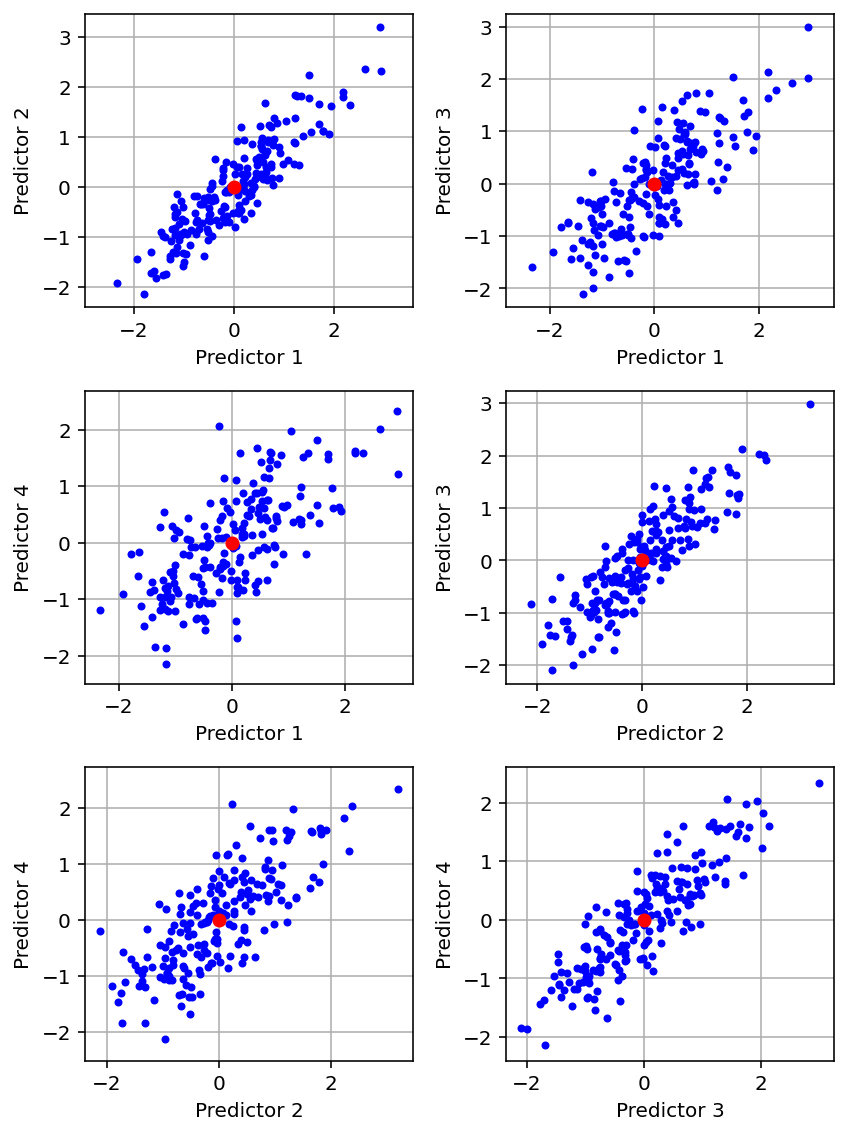

In [ ]:
# Plot various projections of the samples.

fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(6,8))

plt.subplot(3,2,1)
plt.plot(x[:,0], x[:,1], 'b.')
plt.plot(mu[0], mu[1], 'ro')
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 2')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(x[:,0], x[:,2], 'b.')
plt.plot(mu[0], mu[2], 'ro')
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 3')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(x[:,0], x[:,3], 'b.')
plt.plot(mu[0], mu[3], 'ro')
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 4')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(x[:,1], x[:,2], 'b.')
plt.plot(mu[1], mu[2], 'ro')
plt.xlabel('Predictor 2')
plt.ylabel('Predictor 3')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(x[:,1], x[:,3], 'b.')
plt.plot(mu[1], mu[3], 'ro')
plt.xlabel('Predictor 2')
plt.ylabel('Predictor 4')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,6)
plt.plot(x[:,2], x[:,3], 'b.')
plt.plot(mu[2], mu[3
                   ], 'ro')
plt.xlabel('Predictor 3')
plt.ylabel('Predictor 4')
plt.axis('equal')
plt.grid(True)
fig.tight_layout()
plt.show()